In [1]:
# # Seed value
# # Apparently you may use different seed values at each stage
# seed_value= 0

# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# # 2. Set the `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)

# # 3. Set the `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# # tf.compat.v1.K.set_session(sess)
# tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2)

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, Activation, MaxPool2D
from keras.losses import categorical_crossentropy
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Load Data

In [3]:
#loading the data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
y_train = train['label']
x_train = train.drop(labels=['label'], axis=1)
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Check for null and missing values

In [6]:
#check for null and missing values
x_train.isnull().values.any()

False

In [7]:
test.isnull().values.any()

False

There is no missing value in the train and the test dataset.

# Normalisation & Encoding
Dividing the values by 255 so that all the values come in the range of [0,1]

In [8]:
x_train = x_train/255.0
test = test/255.0

Reshaping the values to the 28X28X1 matrices, i.e., height=28px, width=28px, channel=1

In [9]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

One-hot encoding the labels(0-9) using keras library

In [10]:
y_train = to_categorical(y_train, num_classes=10)

# Splitting the train and validation dataset

In [11]:
#Splitting the train and validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2)

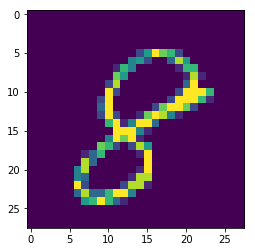

In [12]:
g = plt.imshow(x_train[0][:,:,0])

# Creating the model

In [13]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
#compiling the model
optimiser = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9999, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])

In [15]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
# import multiprocessing
# print(multiprocessing.cpu_count())

# Data Augmentation

In [17]:
#Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Fitting the model

In [18]:
#fit the model
model.fit_generator(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 30, validation_data = (x_val,y_val),
                              steps_per_epoch=x_train.shape[0] // 128,
                              callbacks=[learning_rate_reduction], workers=4)
# model.fit(x_train, y_train, batch_size=128, epochs=4, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/30
295/295 [==============================] - 149s 505ms/step - loss: 1.2464 - accuracy: 0.5793 - val_loss: 0.2091 - val_accuracy: 0.9390
Epoch 2/30
295/295 [==============================] - 148s 502ms/step - loss: 0.4006 - accuracy: 0.8739 - val_loss: 0.1232 - val_accuracy: 0.9621
Epoch 3/30
295/295 [==============================] - 148s 501ms/step - loss: 0.2753 - accuracy: 0.9138 - val_loss: 0.0945 - val_accuracy: 0.9693
Epoch 4/30
295/295 [==============================] - 149s 504ms/step - loss: 0.2301 - accuracy: 0.9310 - val_loss: 0.0817 - val_accuracy: 0.9752
Epoch 5/30
295/295 [==============================] - 150s 510ms/step - loss: 0.1977 - accuracy: 0.9400 - val_loss: 0.0740 - val_accuracy: 0.9760
Epoch 6/30
295/295 [==============================] - 148s 500ms/step - loss: 0.1782 - accuracy: 0.9469 - val_loss: 0.0695 - val_accuracy: 0.9781
Epoch 7/30
295/295 [==============================] - 148s 502ms/step - loss: 0.1609 - accuracy: 0.9515 - val_loss: 0.0636 -

# Predicting results

In [19]:
#predict the model
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [20]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission_final.csv",index=False)